In [2]:
from google.colab import drive
# upload the values of given dataset as csv into colab as 'train.csv'
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/content/sample_data/train.csv')
df

,value
0,29030
1,28930
2,28830
3,29020
4,27000
...,...
255,44509
256,44400
257,43060
258,43369


In [2]:
#There seems to be a seasonality of 60 timesteps and an upwards trend. This will help us extract the trend from the noise.
p = 60
ds = df[p:].reset_index(drop=True)-df[:-p].reset_index(drop=True)
ds

,value
0,-440
1,-90
2,-250
3,-1530
4,1010
...,...
195,4750
196,5250
197,2660
198,1969


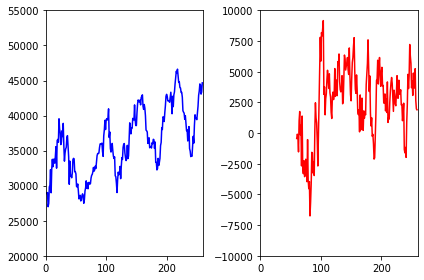

The average gradient is 2.658333333333333


In [22]:
plt.subplot(1,2,1)
plt.plot([i for i in range(260)], df, color='blue')
plt.ylim(2e4, 5.5e4)
plt.xlim(0,260)
plt.subplot(1,2,2)
plt.plot([i+p for i in range(260-p)], ds, color='red')
plt.ylim(-1e4, 1e4)
plt.xlim(0,260)
plt.tight_layout()
plt.show()

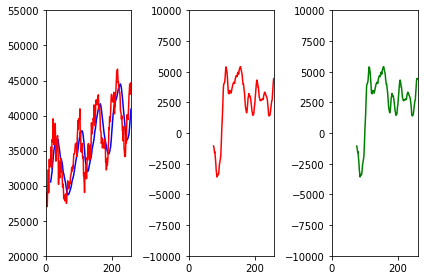

The average gradient of the period-adjusted slope is 42.61595795795795.


In [33]:
#It seems that there is a lot of noise, so we will use a moving average.
def ma(series, window_size):
  movingavr = []
  for time in range(len(series) - window_size):
    movingavr.append(series[time:time + window_size].mean())
  return np.array(movingavr)
ws = 15
value_ma = ma(df, ws)
trend_ma = ma(ds, ws)
plt.subplot(1,3,1)
plt.plot([i+ws for i in range(260-ws)], value_ma, color='blue')
plt.plot([i for i in range(260)], df, color='red')
plt.ylim(2e4, 5.5e4)
plt.xlim(0,260)
plt.subplot(1,3,2)
plt.plot([i+p+ws for i in range(260-p-ws)], value_ma[p:]-value_ma[:-p], color='red') #trend of moving average
plt.ylim(-1e4, 1e4)
plt.xlim(0,260)
plt.subplot(1,3,3)
plt.plot([i+p+ws for i in range(260-p-ws)], trend_ma, color='green') #moving average of the original trendline
plt.ylim(-1e4, 1e4)
plt.xlim(0,260)
plt.tight_layout()
plt.show()
g = np.mean(trend_ma)/p
print(f"The average gradient of the period-adjusted slope is {g}.")
#Notice how red and green are the same. This is because the functions are commutative.

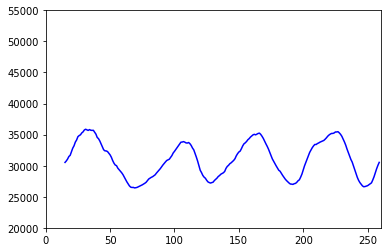

The average distance between peak and trough is 3500.2487657657657.


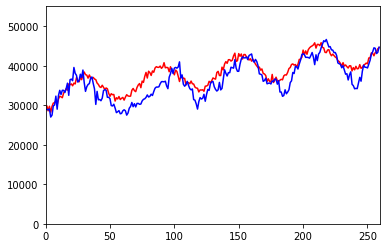

The mean absolute error of the prediction is 2200.1084017772955.


In [34]:
#We can thus model this relationship using an inverted cosine curve.
#We will use the moving average of the curve to generate predictions.
import tensorflow as tf
import keras.backend as K

maxmin = [value_ma[i] - g*i for i in range(len(value_ma))]
plt.plot([i+ws for i in range(260-ws)], maxmin, color='blue')
plt.ylim(2e4, 5.5e4)
plt.xlim(0,260)
plt.show() # just to visualize
amplitude = (np.mean([sorted(maxmin)[-i] for i in range(4)]) - np.mean([sorted(maxmin)[i] for i in range(4)]))/2
print(f"The average distance between peak and trough is {amplitude}.")

errors = np.array([df.iloc[i+ws] - value_ma[i] for i in range(len(value_ma))])
error_std = np.std(errors)

def predict(timestep):
  return -1*amplitude*np.cos((2*np.pi/p)*timestep)+g*timestep+(df.iloc[0]+amplitude*np.cos(2*np.pi/p))+np.random.normal(loc=0.0, scale=error_std/5)

preds = np.array([predict(i) for i in range(260)])
truth = np.array(df)

plt.plot([i for i in range(260)], [predict(i) for i in range(260)], color='red')
plt.plot([i for i in range(260)], df, color='blue')
plt.ylim(0, 5.5e4)
plt.xlim(0,260)
plt.show()
mae = K.eval(tf.keras.metrics.mean_absolute_error(truth.T, preds.T)[0])
print(f"The mean absolute error of the prediction is {mae}.")

[[ 2.27823333e+03]
 [-1.75100000e+02]
 [ 8.32566667e+02]
 [ 1.21823333e+03]
 [ 1.23990000e+03]
 [ 2.34860000e+03]
 [ 2.31493333e+03]
 [ 4.41966667e+02]
 [-1.14973333e+03]
 [-5.11006667e+03]
 [-1.85040000e+03]
 [-4.01606667e+03]
 [-3.85640000e+03]
 [-4.13573333e+03]
 [-3.38670000e+03]
 [-1.39203333e+03]
 [-1.22803333e+03]
 [-1.29773333e+03]
 [-3.05940000e+03]
 [-3.03373333e+03]
 [-3.22470000e+03]
 [-4.83036667e+03]
 [-4.71136667e+03]
 [-3.95600000e+03]
 [-4.65536667e+03]
 [-5.53940000e+03]
 [-5.06140000e+03]
 [-4.51040000e+03]
 [-5.00270000e+03]
 [-4.60673333e+03]
 [-3.57110000e+03]
 [-3.08310000e+03]
 [-3.18776667e+03]
 [-4.07510000e+03]
 [-3.29676667e+03]
 [-1.81813333e+03]
 [-1.12413333e+03]
 [ 1.34500000e+02]
 [-7.74833333e+02]
 [ 1.33500000e+02]
 [-6.92466667e+02]
 [ 3.29900000e+02]
 [ 3.60566667e+02]
 [ 1.62900000e+02]
 [ 2.64233333e+02]
 [ 1.10423333e+03]
 [ 1.59220000e+03]
 [ 1.80286667e+03]
 [ 2.23553333e+03]
 [ 2.86656667e+03]
 [ 2.31790000e+03]
 [ 2.48456667e+03]
 [ 2.9462333

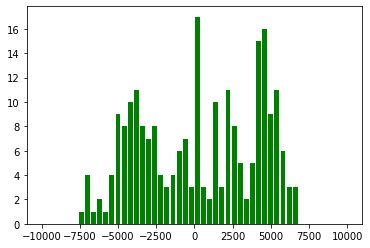

3827.5336820795


In [8]:
#Visualization of errors
errors = np.array([df.iloc[i+ws] - value_ma[i] for i in range(len(value_ma))])

bins=50
r=(-1e4,1e4)
plt.hist(errors, bins, r, color = 'green',histtype = 'bar', rwidth = 0.8)
plt.show()
error_std = np.std(errors)